In [40]:
import plotly.graph_objects as go
# import kaleido
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
import numpy as np
import json

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# local modules 
import sys
sys.path.insert(0, "../scripts")
import helpers as h
import seaborn as sns

import matplotlib.pyplot as plt

In [53]:
a00, a01 = h.import_desired_data("A", "15T")
# TODO edit in function 
a00.set_index(a00["DateTime"].values, inplace=True)
a01.set_index(a01["DateTime"].values, inplace=True)
print(a00["Window Open"].unique(), a01["Window Open"].unique(), a00.columns)

temp = a01["Temp C"]
time = a01["DateTime"]

[1.] [0. 1.] Index(['DateTime', 'Temp C', 'RH %', 'Room', 'Ambient Temp', 'Ambient RH',
       'Window Open'],
      dtype='object')


## frequency based approach.. kind of ...

In [193]:
fig = fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(
    x=a01["DateTime"],
    y=h.normalize(a01["Temp C"]), 
    mode='lines',
    name="Variable W/O/C"
), row = 1, col = 1)

fig.add_trace(go.Scatter(
    x=a01["DateTime"],
    y=h.normalize(a00["Temp C"]), 
    mode='lines',
    name="Constant W/O/C"
), row = 1, col = 1)

fig.add_trace(go.Scatter(
    x=a01["DateTime"],
    y=h.normalize(a00["Ambient Temp"]), 
    name="Ambient",
    mode='lines',
), row = 1, col = 1)

fig.update_layout(xaxis_title='Dates',
                  yaxis_title='Temperature (ºC)',
)

In [49]:
temp = a01["Temp C"]
n = len(temp)
t = np.arange(n)

In [112]:
def make_fit(series, A, w, phi, w_t_var):
    n = len(series)
    t = np.arange(n)

    w_t = np.random.normal(0, 1, size=w_t_var)
    x_t = A*np.cos(2*np.pi*w*t + phi) # + w_t

    return x_t, t

In [204]:

x_t, t = make_fit(series=temp, A=-0.5, w=3.9*(1/(len(temp))), phi=0.8, w_t_var=1)
x_t += 0.5
pi = np.pi
x_t2, t2 = make_fit(series=temp, A=-0.25, w=3.9*(1/(len(temp))), 
    phi=-2.3, w_t_var=1)
x_t2 += 0.3

sum_xt = x_t + x_t2

norm_temp = h.normalize(temp)
dif_xt = norm_temp - x_t 
ddt_dif_xt= h.normalize(np.gradient(dif_xt))

dif_sum = sum_xt - norm_temp
ddt_dif_sum = h.normalize(np.gradient(dif_sum))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time,
    y=a01["Window Open"],
    name="Window",
    mode='lines',
))


fig.add_trace(go.Scatter(
    x=time,
    y=h.normalize(temp),
    mode='lines',
    name="Var Temp, Norm"
))
fig.add_trace(go.Scatter(
    x=time,
    y=x_t,
    name="x_t1",
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=time,
    y=x_t2,
    name="x_t2",
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=time,
    y=sum_xt,
    name="sum_xt",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=dif_xt,
    name="dif_xt",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=dif_sum,
    name="dif - sum_xt",
    mode='lines',
))


fig.add_trace(go.Scatter(
    x=time,
    y=ddt_dif_xt,
    name="ddt_dif_xt",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=ddt_dif_sum,
    name="ddt_dif_sum",
    mode='lines',
))




### smoothing var temp and running back...

In [219]:
tn = h.normalize(temp)
tns = h.normalize(temp).ewm(com=4).mean()

xt1, t = make_fit(series=temp, A=-0.5, w=3.9*(1/(len(temp))), phi=0.8, w_t_var=1)
xt1 += 0.5

dif_xt1 = tns - xt1 
ddt_dif_xt1 = h.normalize(np.gradient(dif_xt))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time,
    y=a01["Window Open"],
    name="Window",
    mode='lines',
))


fig.add_trace(go.Scatter(
    x=time,
    y=tn,
    mode='lines',
    name="tn = Var Temp, Norm"
))

fig.add_trace(go.Scatter(
    x=time,
    y=tns,
    mode='lines',
    name="tns = Var Temp, Norm + Smooth"
))

fig.add_trace(go.Scatter(
    x=time,
    y=xt1,
    name="xt1",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=dif_xt1,
    name="dif_xt",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=ddt_dif_xt1,
    name="ddt_dif_xt1",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=pd.Series(ddt_dif_xt1).ewm(com=4).mean(),
    name="smooth_ddt_dif_xt1",
    mode='lines',
))

fig.add_trace(go.Scatter(
    x=time,
    y=h.normalize(np.gradient(pd.Series(ddt_dif_xt1).ewm(com=4).mean())),
    name="norm_ddt_smooth_ddt_dif_xt1",
    mode='lines',
))



## statsmodels 

In [3]:
acorr = sm.tsa.acf(a01["Temp C"], nlags = len(a01["Temp C"])-1)

In [33]:
len(a01["Temp C"])/2

192.5

In [44]:
a01["Temp C"].to_csv("../constants/a01.csv")

In [34]:
def create_corr_plot(series, plot_pacf=False):
   
    corr_array = sm.tsa.pacf(series.dropna(), alpha=0.05, nlags=(len(series)//2-1)) if plot_pacf else sm.tsa.acf(series.dropna(), alpha=0.05, nlags=(len(series)-1))
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]
    print(len(corr_array[0]))

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

    return corr_array

In [24]:
corr_array = create_corr_plot(a01["Temp C"])

385


In [36]:
c = create_corr_plot(a01["Temp C"], True)

192


## texbook 

In [37]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

<AxesSubplot:xlabel='LAG', ylabel='ACF'>

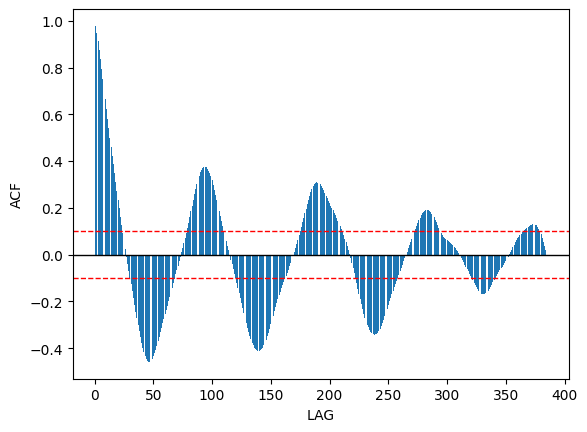

In [41]:
acf1(a01["Temp C"], nlags = (len(a01["Temp C"])-1))

<AxesSubplot:xlabel='LAG', ylabel='PACF'>

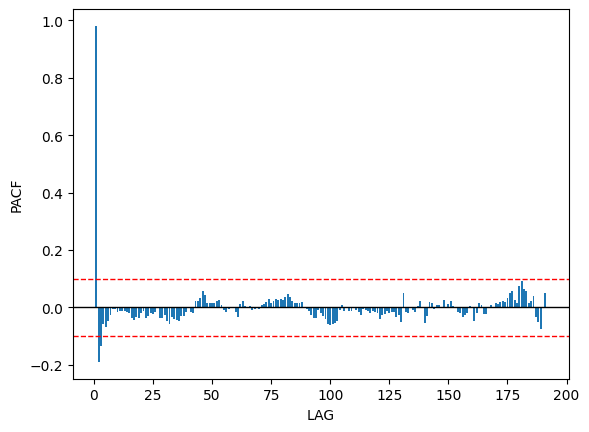

In [42]:
acf1(a01["Temp C"], nlags = (len(a01["Temp C"])//2-1), pacf=True)